<a href="https://colab.research.google.com/github/jagadeesh-usd/AAI530-MetroPT3-PredictiveMaintenance/blob/main/01_EDA_and_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Air Production Unit (APU) Predictive Maintenance EDA

This notebook performs exploratory data analysis on the **MetroPT-3 dataset** —
a real-world industrial sensor dataset collected from an Air Production Unit
aboard a Portuguese metro fleet.

**Dataset:** 1,516,948 observations at 1-second intervals  
**Period:** February 1 – September 1, 2020 (7 months)  
**Sensors:** 7 continuous analog sensors + 8 binary control/alarm signals  
**Documented failures:** 4 events across the observation period

**EDA Objectives:**
- Classify and validate sensor variables by type and physical meaning
- Identify the APU's discrete operating states and control logic behavior
- Detect pre-failure degradation patterns across multiple sensors
- Justify resampling strategy and feature selection decisions for modeling

## Setup and Data Loading

The raw MetroPT-3 dataset is loaded directly from Google Drive. Initial
steps confirm dataset shape, data types, duplicate records, and timestamp
range before any transformation is applied.

In [2]:
# Libraries for data manipulation and numerical operations
import pandas as pd
import numpy as np
import random


# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully with annotations.")

Libraries imported successfully with annotations.


In [3]:
# Import the drive module to access Google Drive file system
from google.colab import drive

# Mount Google Drive to /content/drive
drive.mount('/content/drive')

# Define the absolute path to the input dataset
file_path = '/content/drive/MyDrive/project/data/input/MetroPT3.csv'

Mounted at /content/drive


## Variable Classification and Sensor Types

The Air Production Unit (APU) dataset contains a combination of **continuous (analog) sensor measurements** and **binary (digital) control or alarm signals**.

---

### Continuous Variables (Analog Sensors)

Continuous variables represent physical measurements such as pressure, electrical current, and temperature.  
These variables can take a wide range of numeric values and are suitable for statistical analysis, correlation studies, and time-series modeling.

| Variable | Unit | Description |
|--------|------|-------------|
| **TP2** | bar | Pressure inside the compressor |
| **TP3** | bar | Pressure at the pneumatic panel |
| **H1** | bar | Pressure drop at the cyclonic separator during discharge |
| **DV_pressure** | bar | Pressure drop during air dryer discharge (near zero when compressor is loaded) |
| **Reservoirs** | bar | Downstream air reservoir pressure |
| **Motor_current** | A | Electrical current drawn by the compressor motor, indicating load |
| **Oil_temperature** | °C | Compressor oil temperature |

---

### Binary Variables (Digital Control and Alarm Signals)

Binary variables represent system states, control logic, or safety alarms.  
Although these variables are stored as numeric values (0 or 1), they should be interpreted as **discrete indicators**, not continuous measurements.

| Variable | Description |
|--------|-------------|
| **COMP** | Intake valve control signal (active when compressor is OFF or OFFLOADED) |
| **DV_eletric** | Outlet valve control signal (active when compressor is LOADED) |
| **TOWERS** | Indicates the active air-drying tower (0 = Tower 1, 1 = Tower 2) |
| **MPG** | Load request signal triggered when pressure drops below 8.2 bar |
| **LPS** | Low pressure safety alarm (activated below 7 bar) |
| **Pressure_switch** | Signal indicating air dryer discharge |
| **Oil_level** | Oil level alarm (active when oil is below expected level) |
| **Caudal_impulses** | Airflow pulse indicator measuring air delivery events |

---

### Notes for Analysis

- Continuous variables will be analyzed using descriptive statistics, time-series plots, and correlation analysis.
- Binary variables will be treated as event or state indicators and interpreted based on activation frequency and timing.


In [4]:
print("Loading Dataset...")
df = pd.read_csv(file_path)
print("Done!")

Loading Dataset...
Done!


In [5]:
# Inspect the Structure
print(f"Dataset Shape: {df.shape}")
df.info()

Dataset Shape: (1516948, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516948 entries, 0 to 1516947
Data columns (total 17 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Unnamed: 0       1516948 non-null  int64  
 1   timestamp        1516948 non-null  object 
 2   TP2              1516948 non-null  float64
 3   TP3              1516948 non-null  float64
 4   H1               1516948 non-null  float64
 5   DV_pressure      1516948 non-null  float64
 6   Reservoirs       1516948 non-null  float64
 7   Oil_temperature  1516948 non-null  float64
 8   Motor_current    1516948 non-null  float64
 9   COMP             1516948 non-null  float64
 10  DV_eletric       1516948 non-null  float64
 11  Towers           1516948 non-null  float64
 12  MPG              1516948 non-null  float64
 13  LPS              1516948 non-null  float64
 14  Pressure_switch  1516948 non-null  float64
 15  Oil_level        1516948 non-null  fl

## Dataset Structure – Initial Interpretation

The dataset contains **1,516,948 observations and 17 variables**, representing high-frequency sensor data collected from an Air Production Unit (APU). Each record corresponds to a time-stamped snapshot of the compressor system.

The dataset shows **no missing values**, indicating high data quality suitable for time-series analysis. One column (`Unnamed: 0`) is a non-informative index generated during data export and will be removed. The `timestamp` column is currently stored as an object and will be converted to a datetime format for temporal analysis.

The remaining variables include a mix of **continuous physical measurements** (pressure, motor current, temperature) and **binary control and alarm signals** stored as numeric values.


In [6]:
# Identify duplicate rows (True/False) and sum them (True=1) to get the total count
df.duplicated().sum()

np.int64(0)

No duplicate rows detected across 1,516,948 records. Combined with the
absence of missing values confirmed by `df.info()`, the dataset requires
no imputation or deduplication — preprocessing can proceed directly to
timestamp conversion and column cleanup.

In [7]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

In [8]:
# Get min and max timestamp
min_ts = df.index.min()
max_ts = df.index.max()

print(f"Minimum Timestamp: {min_ts}")
print(f"Maximum Timestamp: {max_ts}")

Minimum Timestamp: 2020-02-01 00:00:00
Maximum Timestamp: 2020-09-01 03:59:50


The dataset spans from **February 1, 2020 to September 1, 2020**, covering approximately **seven months of continuous operation** of the Air Production Unit. This extended and uninterrupted time range provides sufficient temporal coverage to capture normal operating behavior, state transitions, and rare events, making the data suitable for time-series analysis and predictive maintenance modeling.


In [9]:
# Drop the redundant 'Unnamed: 0' column
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

### Variable Classification

Variables are explicitly classified before analysis to ensure correct
treatment throughout the notebook. Continuous sensors use mean aggregation
during resampling. Binary signals use max aggregation — a single activation
within a window must not be averaged away. This distinction directly
governs the `resample_data` function defined below.

In [10]:
# Continuous (Analog) Variables
continuous_vars = [
    'TP2',
    'TP3',
    'H1',
    'DV_pressure',
    'Reservoirs',
    'Motor_current',
    'Oil_temperature'
]

# Binary (Digital Control / Alarm) Variables
binary_vars = [
    'COMP',
    'DV_eletric',
    'Towers',
    'MPG',
    'LPS',
    'Pressure_switch',
    'Oil_level',
    'Caudal_impulses'
]


## Continuous Variable Distributions

In [19]:
df[continuous_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
TP2,1516948.0,1.367826,3.250930,-0.032,-0.014,-0.012,-0.0100,10.676
TP3,1516948.0,8.984611,0.639095,0.730,8.492,8.960,9.4920,10.302
H1,1516948.0,7.568155,3.333200,-0.036,8.254,8.784,9.3740,10.288
DV_pressure,1516948.0,0.055956,0.382402,-0.032,-0.022,-0.020,-0.0180,9.844
Reservoirs,1516948.0,8.985233,0.638307,0.712,8.494,8.960,9.4920,10.300
Motor_current,1516948.0,2.050171,2.302053,0.020,0.040,0.045,3.8075,9.295
Oil_temperature,1516948.0,62.644182,6.516261,15.400,57.775,62.700,67.2500,89.050




| Variable | Key Observations | Interpretation |
|--------|-----------------|----------------|
| **TP2** | Median near 0 bar; maximum ~10.7 bar | Compressor pressure remains near zero for most of the time, indicating frequent off or offloaded states, with pressure increasing only during active compression cycles |
| **TP3** | Stable around ~9 bar with low variance | Pneumatic panel pressure is well-regulated and remains stable during normal operation |
| **H1** | High variability with occasional spikes | Pressure drop events are intermittent and correspond to moisture discharge from the cyclonic separator |
| **DV_pressure** | Near-zero median with rare high spikes | Acts as an event indicator; near-zero values correspond to loaded operation, while spikes indicate air dryer discharge |
| **Reservoirs** | Closely matches TP3 distribution | Reservoir pressure is stable and consistent with downstream pneumatic requirements |
| **Motor_current** | Low median with wide range up to ~9.3 A | Confirms multiple operating states: off, offloaded, loaded, and startup conditions |
| **Oil_temperature** | Gradual variation between ~15–89 °C | Reflects long-term thermal behavior rather than short-term operational events |



## Binary Variable Distributions

In [11]:
# Loop through each binary variable to see its own distribution
for binary_var in binary_vars:
    print(f'Distribution of {binary_var}')

    # Calculate counts and percentages
    counts = df[binary_var].value_counts()
    percentages = df[binary_var].value_counts(normalize=True) * 100

    # Combine into a clean dataframe
    dist_df = pd.DataFrame({'Count': counts, 'Percentage (%)': percentages})
    display(dist_df)
    print("\n")

Distribution of COMP


,Count,Percentage (%)
COMP,,
1.0,1269620,83.695684
0.0,247328,16.304316




Distribution of DV_eletric


,Count,Percentage (%)
DV_eletric,,
0.0,1273310,83.938935
1.0,243638,16.061065




Distribution of Towers


,Count,Percentage (%)
Towers,,
1.0,1395362,91.984827
0.0,121586,8.015173




Distribution of MPG


,Count,Percentage (%)
MPG,,
1.0,1263108,83.266401
0.0,253840,16.733599




Distribution of LPS


,Count,Percentage (%)
LPS,,
0.0,1511760,99.657998
1.0,5188,0.342002




Distribution of Pressure_switch


,Count,Percentage (%)
Pressure_switch,,
1.0,1503958,99.143675
0.0,12990,0.856325




Distribution of Oil_level


,Count,Percentage (%)
Oil_level,,
1.0,1371557,90.415558
0.0,145391,9.584442




Distribution of Caudal_impulses


,Count,Percentage (%)
Caudal_impulses,,
1.0,1421542,93.710661
0.0,95406,6.289339


| Variable | Active (%) | Key Observation | Interpretation |
|--------|------------|-----------------|----------------|
| **COMP** | 83.70 | Frequently active | Compressor is predominantly in OFF or OFFLOADED states, with active compression occurring intermittently |
| **DV_eletric** | 16.06 | Infrequently active | Loaded operation occurs only when pressure recovery is required |
| **TOWERS** | 91.98 | Highly skewed | One dryer tower is active most of the time, indicating stable but asymmetric tower utilization |
| **MPG** | 83.27 | Frequently active | System frequently requests readiness for compression when pressure drops |
| **LPS** | 0.34 | Very rare | Low-pressure alarm events are infrequent, indicating stable pressure conditions |
| **Pressure_switch** | 99.14 | Almost always active | Dryer discharge detection operates continuously under normal conditions |
| **Oil_level** | 90.42 | Mostly active | Oil level remains within acceptable limits for most of the operation |
| **Caudal_impulses** | 93.71 | Frequently active | Continuous airflow delivery to downstream pneumatic systems is observed |



## Resampling (Down-sampling)

### Temporal Resampling and Data Reduction

The original dataset is sampled at a high temporal resolution (approximately 10 second intervals), resulting in over 1.5 million observations. While this resolution is valuable for monitoring real-time behavior, it is computationally expensive and unnecessary for modeling long-term operational patterns of the Air Production Unit (APU).

To balance **computational efficiency** and **information preservation**, the data is down-sampled to **1-minute intervals** using mean aggregation. This temporal resolution is sufficient to capture pressure trends, operating state transitions, and thermal behavior, while significantly reducing data volume for deep learning model training.

Short gaps introduced during resampling are handled using forward-fill interpolation, under the assumption that sensor readings remain stable over short time windows. Any remaining missing values are removed to ensure clean input for subsequent modeling.


In [12]:
def resample_data(df, interval):
    """
    Resamples the dataframe to the specified interval.
    - Continuous sensors: mean aggregation
    - Binary signals: max aggregation (preserves any activation within window)
    """
    print(f"Resampling to {interval} intervals...")

    # continuous_cols = ['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
    #                    'Motor_current', 'Oil_temperature']

    # binary_cols = ['COMP', 'DV_electric', 'Towers', 'MPG',
    #                'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']

    df_continuous = df[continuous_vars].resample(interval).mean()
    df_binary = df[binary_vars].resample(interval).max()

    df_resampled = pd.concat([df_continuous, df_binary], axis=1)

    # Forward fill to handle short sensor dropouts
    df_resampled = df_resampled.ffill()

    # Drop any remaining NaNs
    df_resampled = df_resampled.dropna()

    print(f"Resampled Data Shape: {df_resampled.shape}")
    return df_resampled

In [14]:
# Define Failure Timestamps (Red Lines)
failure_events = [
    pd.Timestamp('2020-04-18 00:00:00'),
    pd.Timestamp('2020-05-29 23:30:00'),
    pd.Timestamp('2020-06-05 10:00:00'),
    pd.Timestamp('2020-07-15 14:30:00')
]

In [13]:
def plot_sensor_data_with_failures(df_input, continuous_vars, failure_events):
    """
    Plots continuous sensor data and marks failure events with red dashed lines.
    """
    # Loop and Plot Each Variable
    for col in continuous_vars:
        plt.figure(figsize=(15, 4)) # Wide and short for timeline view

        # Plot the sensor data
        plt.plot(df_input.index, df_input[col], label=col, color='#1f77b4', linewidth=0.8)

        # Add Red Vertical Lines for Failures
        for failure_time in failure_events:
            if df_input.index.min() <= failure_time <= df_input.index.max():
                plt.axvline(x=failure_time, color='red', linestyle='--', linewidth=2, alpha=0.7)
                # Add text label only once to avoid clutter
                if col == continuous_vars[0]:
                    plt.text(failure_time, df_input[col].max(), ' FAILURE', color='red', rotation=90)

        plt.title(f'{col} over Time (Red Dashed Line = Failure Event)', fontsize=12)
        plt.ylabel(col)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

#### Resample 1 minute

In [15]:
df_resampled = resample_data(df, '1min')

Resampling to 1min intervals...
Resampled Data Shape: (306960, 15)


The dataset is first resampled to 1-minute intervals — the resolution
saved for LSTM model input. This reduces 1,516,948 rows to 306,960
while preserving failure-relevant dynamics within each window.


### Time-Series Inspection at 1-Minute Resolution

Each continuous sensor is plotted over the full 7-month period with
known failure events marked as red dashed lines. At this resolution,
high-frequency compression cycles are visible but long-term degradation
trends are obscured by noise — motivating the 60-minute resampling below.

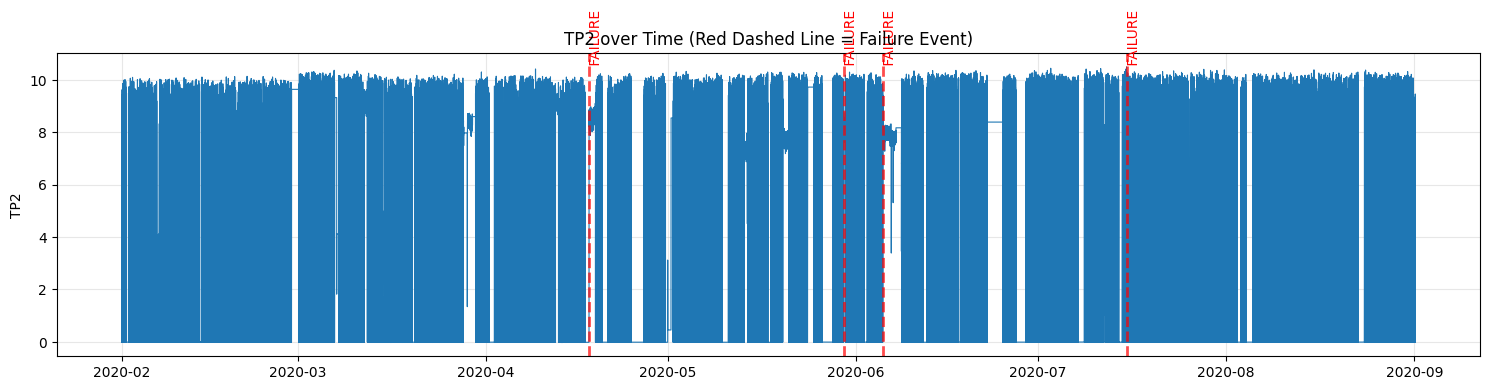

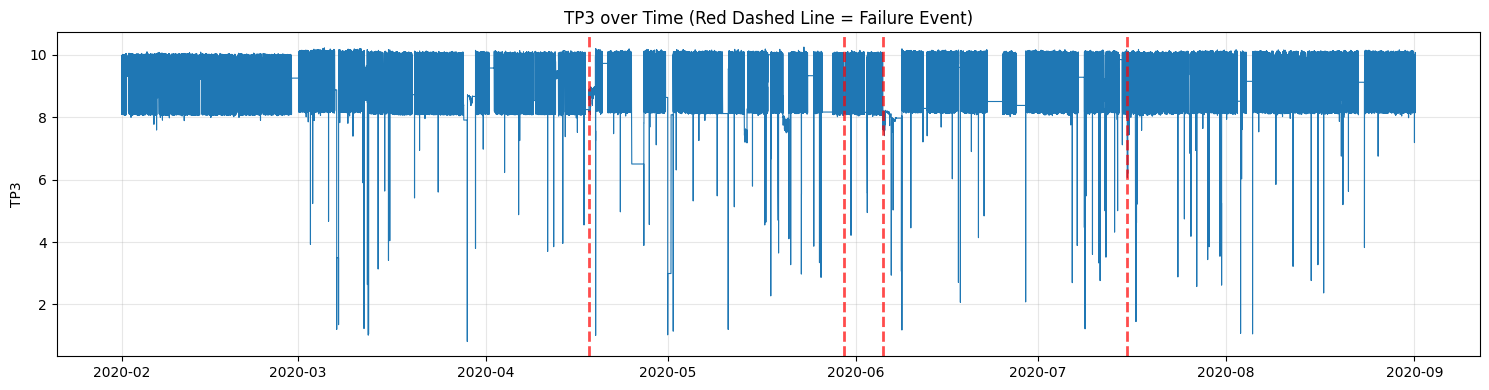

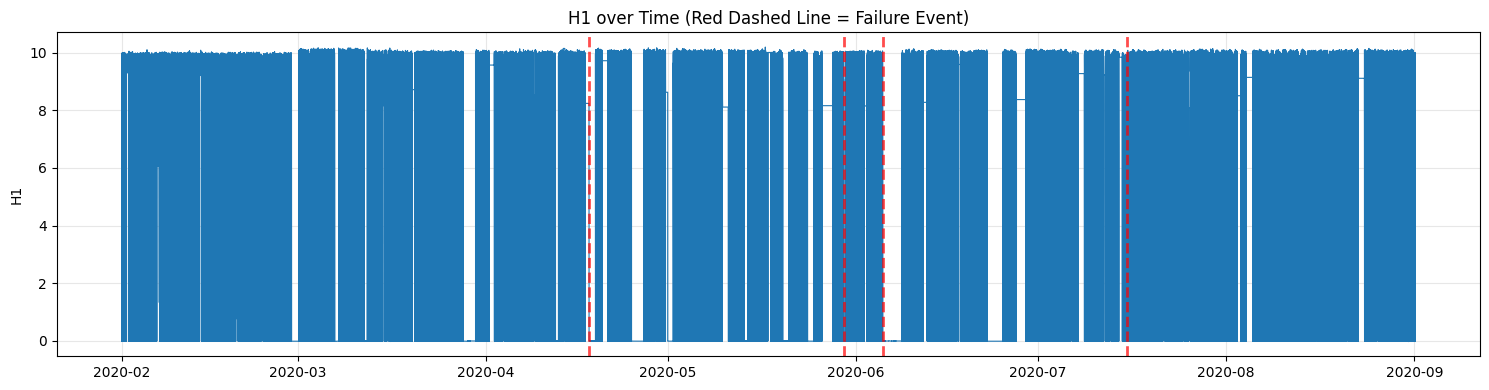

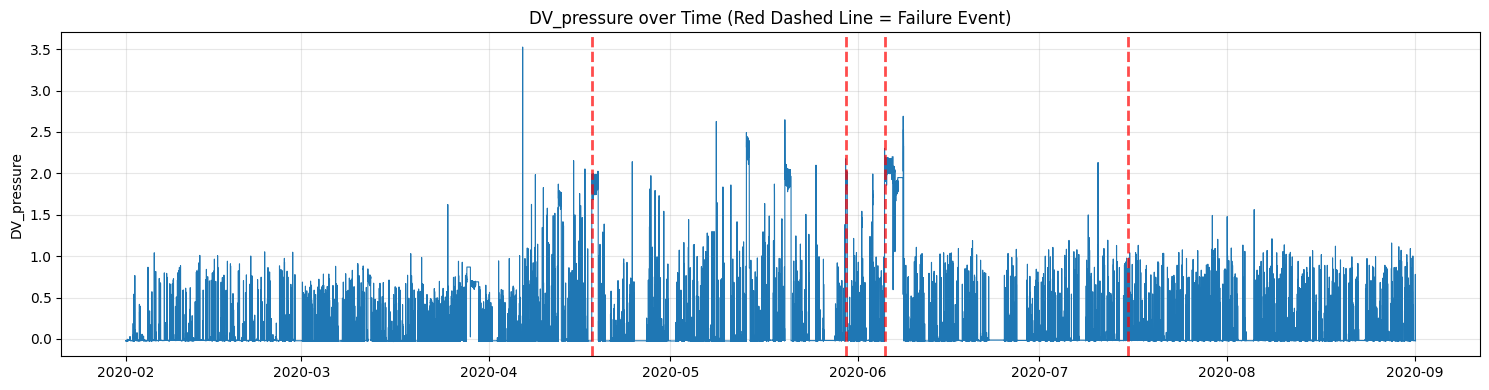

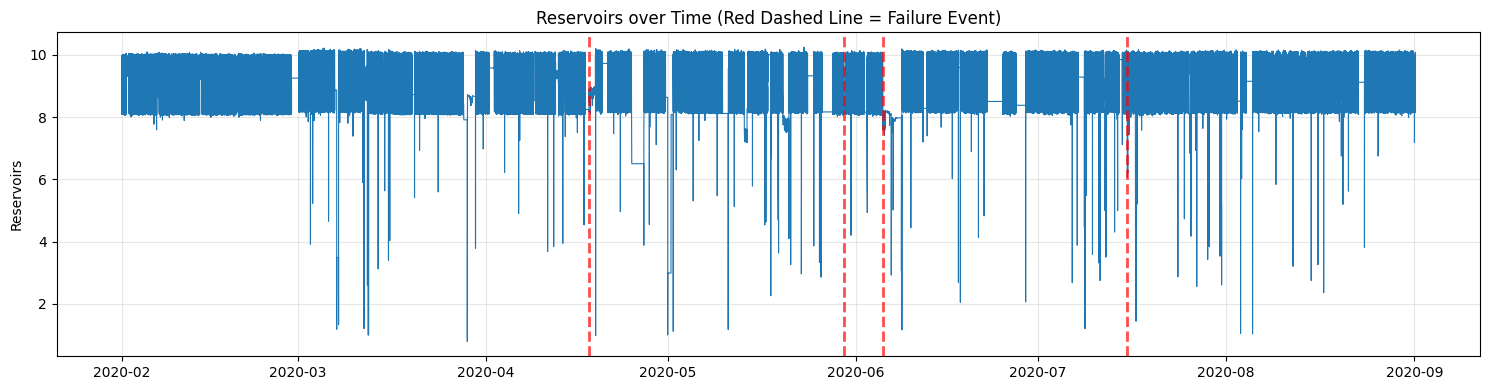

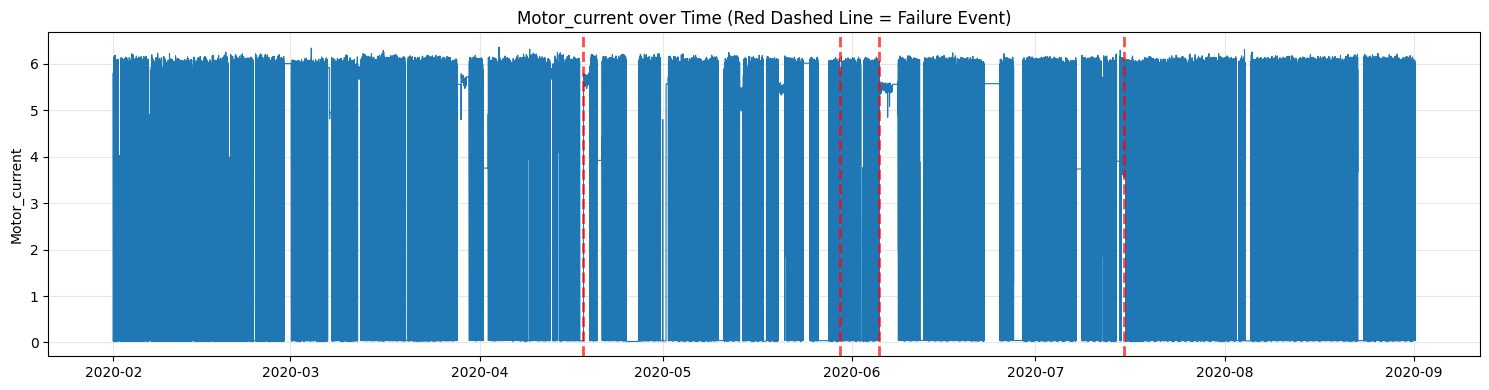

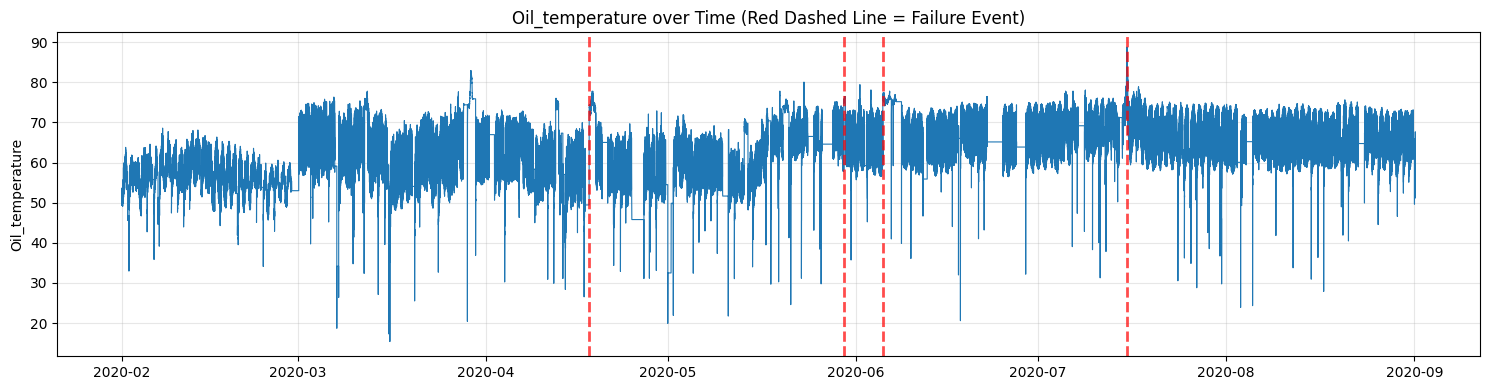

In [16]:
plot_sensor_data_with_failures(df_resampled, continuous_vars, failure_events)

In [17]:
df_resampled = resample_data(df, '60min')

Resampling to 60min intervals...
Resampled Data Shape: (5116, 15)


Resampled to 60-minute intervals for visualization only — not saved for
modeling. At this resolution, compression cycle noise is filtered out,
revealing long-term trends in oil temperature drift, pressure variability,
and motor current escalation that are not visible at 1-minute resolution.

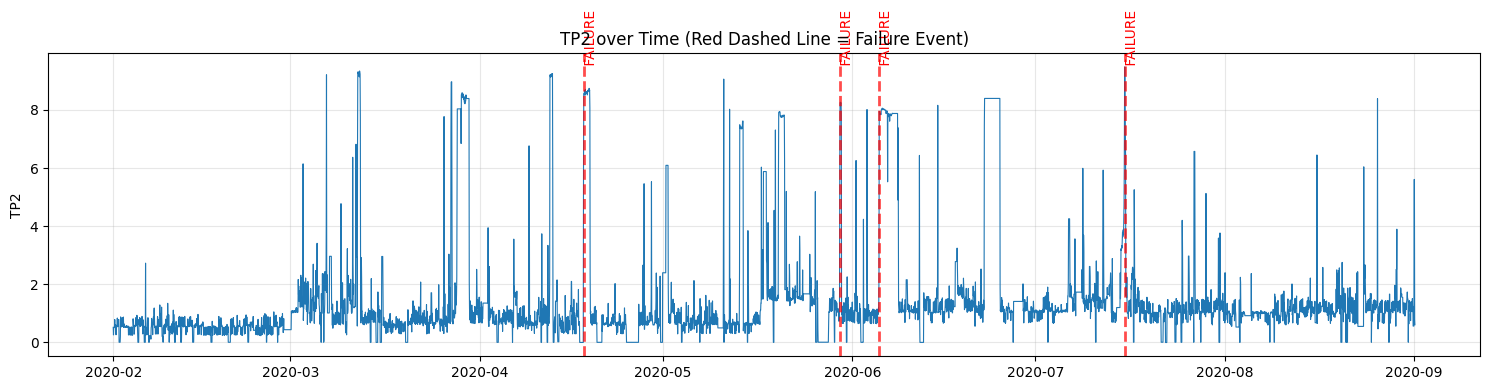

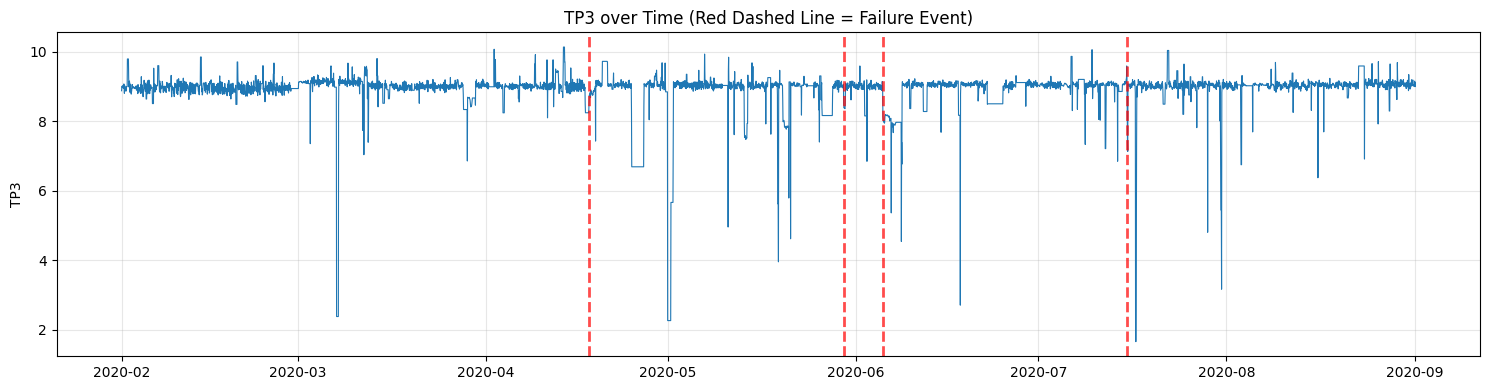

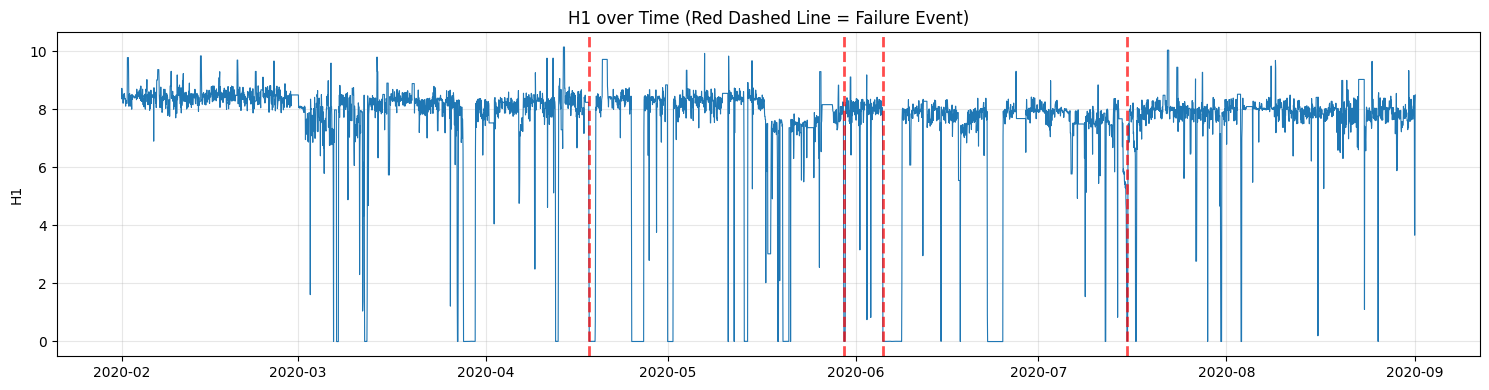

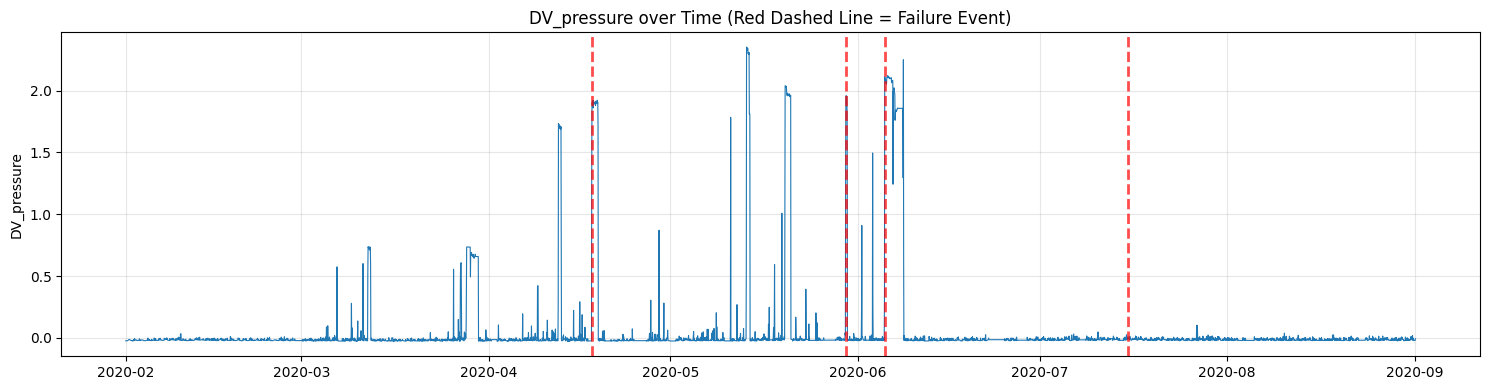

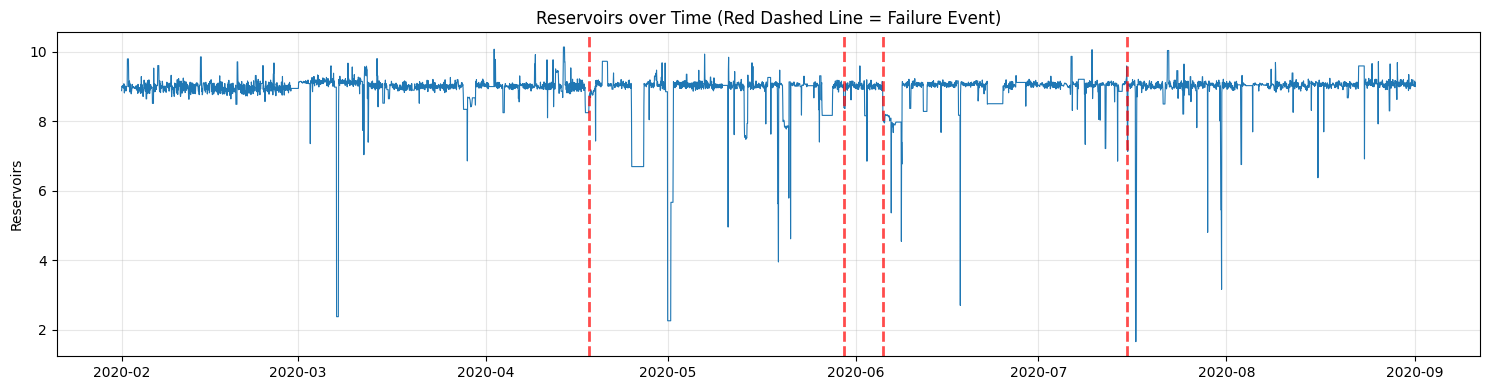

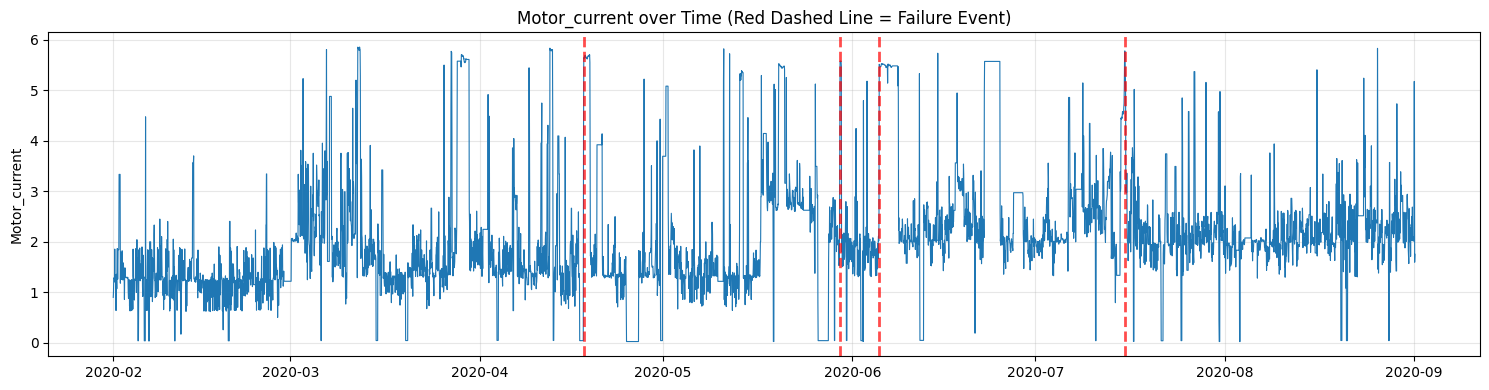

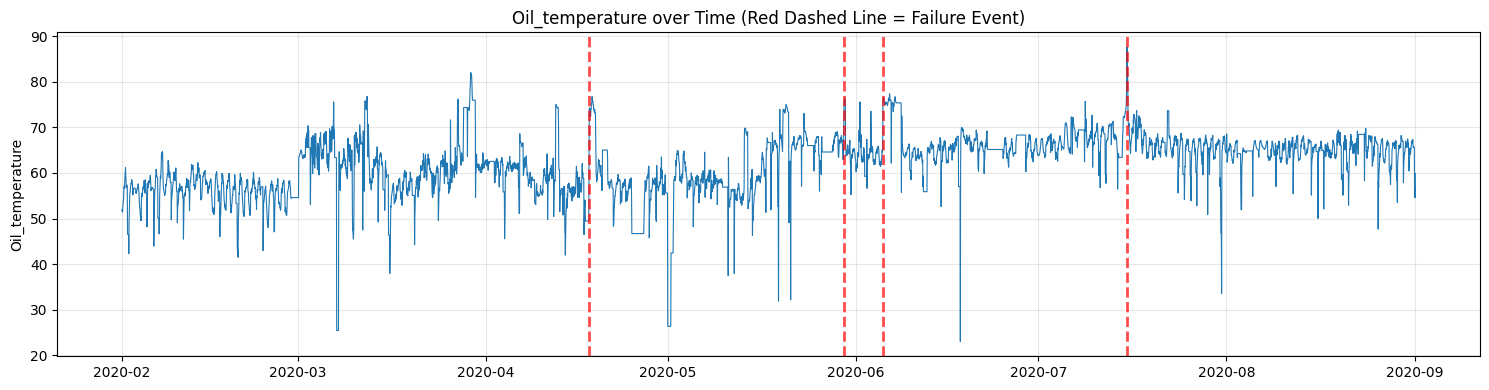

In [18]:
plot_sensor_data_with_failures(df_resampled, continuous_vars, failure_events)

## Resampling Strategy: EDA vs. Modeling

Two resampling intervals are used, each serving a distinct purpose.

### EDA Visualization — 60-Minute Intervals
For exploratory plots (time-series trends, distributions, correlation heatmap, and control-logic validation), the data is resampled to **60-minute intervals**. This reduces high-frequency noise and short-duration micro-states that obscure long-term patterns, making trends in oil temperature drift, pressure behavior, and motor current state transitions visually interpretable.

This resolution is used **for analysis only** and is not saved for modeling.

### Modeling Input — 1-Minute Intervals
For deep learning, the data is resampled to **1-minute intervals** and will be saved as the output file. This resolution:
- Preserves short-duration events such as pressure drops, LPS activations, and motor current spikes that are diagnostically significant
- Provides sufficient temporal granularity for LSTM sliding windows (30–60 minute lookback = 30–60 time steps)
- Reduces the raw 1,516,948 observations (~1 sample/second) to 306,960 rows — a ~5× compression that lowers computational cost without losing failure-relevant dynamics


After aggregating the sensor data to 60-minute intervals, the time-series plots reveal higher-level operational behavior of the Air Production Unit rather than individual compressor cycles. While no single sensor exhibits an abrupt or catastrophic deviation at the failure timestamps, consistent multi-sensor changes in variability and operational effort are observed around these periods.

- **TP3 and Reservoir Pressure:**  
  Downstream pressures remain largely within nominal operating ranges throughout the observation period, including during failure events. This indicates that the system continues to meet pneumatic demand, even as internal conditions degrade.

- **TP2 and Motor Current:**  
  Both variables show increased variability and more frequent high-load intervals near failure windows. This suggests that the compressor must operate more aggressively to maintain stable downstream pressure, reflecting increased mechanical stress rather than immediate loss of function.

- **H1 and DV_pressure:**  
  H1 shows periodic deep drops to near 0 bar throughout the observation period,
  representing normal separator discharge cycles. These drops become more irregular in timing and duration near failure events, suggesting disrupted cycling under degraded conditions.

  DV_pressure remains near zero during normal operation but shows a clear escalation in spike magnitude and frequency between April and June — the period containing three of the four failure events. This progressive increase suggests growing moisture load or reduced dryer efficiency ahead of failure, rather than a sudden fault.

- **Oil Temperature:**  
  Oil temperature evolves smoothly over time but displays elevated variance and occasional abrupt drops near failure periods, suggesting thermal instability or transient cooling events under increased load.

Overall, the failure events are characterized not by sudden pressure collapse, but by **gradual degradation manifested as increased variability, higher operational effort, and irregular auxiliary subsystem behavior across multiple sensors**. These patterns are subtle and distributed, supporting the use of multivariate, unsupervised anomaly detection methods rather than threshold-based fault detection.


## Distribution and Relationship Analysis

After examining temporal behavior, analyzing the statistical distributions and inter-variable relationships of key continuous sensors. This step aims to:
1.  **Identify Multi-modal Behavior:** Detect distinct operating states (Off, Offloaded, Loaded) manifesting as clusters in the data.
2.  **Validate Physical Physics:** Confirm the expected relationship between electrical load (Motor Current) and pressure generation.
3.  **Assess Correlations:** Identify redundant variables, while acknowledging that the system's nonlinear, state-driven nature may not be fully captured by linear correlation metrics.

#### A. Distribution Plots (Histograms)

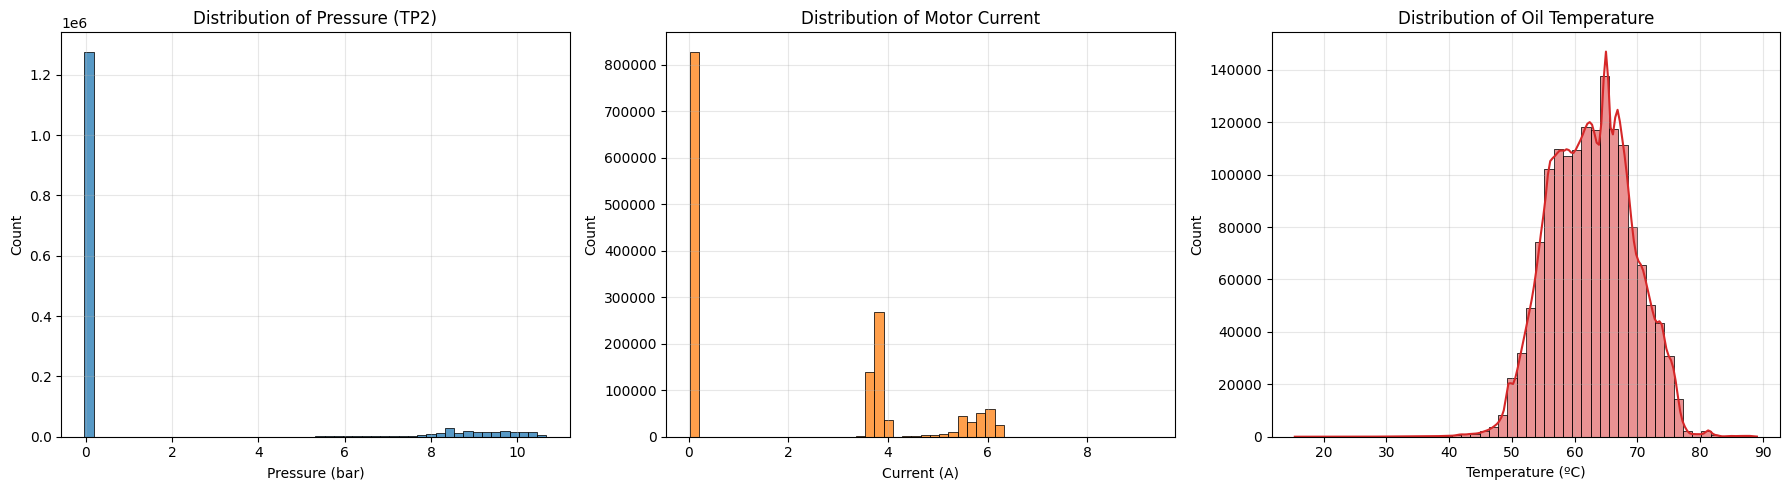

In [28]:
# kde=False for Pressure and Current to clearly see the discrete states (humps).
# keep kde=True for Temperature as it is a continuous, slow-moving variable.

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Pressure Distribution
sns.histplot(df['TP2'], bins=50, kde=False, ax=axes[0], color='#1f77b4')
axes[0].set_title('Distribution of Pressure (TP2)')
axes[0].set_xlabel('Pressure (bar)')
axes[0].grid(True, alpha=0.3)

# Plot 2: Motor Current Distribution
sns.histplot(df['Motor_current'], bins=50, kde=False, ax=axes[1], color='#ff7f0e')
axes[1].set_title('Distribution of Motor Current')
axes[1].set_xlabel('Current (A)')
axes[1].grid(True, alpha=0.3)

# Plot 3: Oil Temperature Distribution
sns.histplot(df['Oil_temperature'], bins=50, kde=True, ax=axes[2], color='#d62728')
axes[2].set_title('Distribution of Oil Temperature')
axes[2].set_xlabel('Temperature (ºC)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



The distribution analysis reveals a fundamental decoupling between the system's control states and its thermal response:

- Discrete Operational States (Motor Current & TP2):
The Motor Current distribution is explicitly trimodal, revealing three distinct regimes: System Off(0A), Offloaded (4A), and Loaded Compression (6A). Similarly, TP2 (Inter-stage Pressure) exhibits a bimodal distribution, toggling between near-zero pressure (unloaded) and operating pressure (loaded). This confirms that the system dynamics are driven by discrete switching logic rather than continuous modulation.

- Continuous Thermal Inertia (Oil Temperature):
In contrast to the instantaneous switching of the motor, the Oil Temperature follows a unimodal, near-Gaussian distribution. This reflects the thermal mass of the fluid, which acts as an integrator of the motor's energy state. The smooth distribution confirms that thermal anomalies will manifest as gradual shifts in the distribution's mean or variance, rather than the formation of new modes.

- Data Imbalance:
The TP2 histogram indicates a significant class imbalance, with a dominant proportion of data points centered at zero. This suggests the compressor spends a substantial portion of the observation window in an "Off" or "Offloaded" state, which must be accounted for during model training to prevent bias toward the null state.

Conclusion:
These findings confirm that the machine is a hybrid system: it possesses discrete electrical states but generates continuous thermal consequences. Consequently, simple linear correlation analysis may be misleading. Effective anomaly detection must be state-aware, evaluating health signals relative to the specific operating mode (Idle vs. Loaded) rather than the global average.



#### B. Scatter Plot (Physics Check)

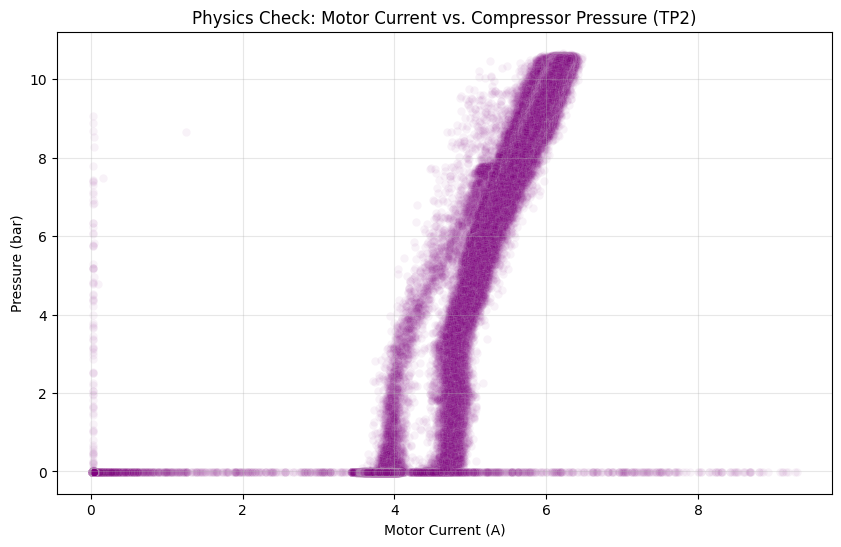

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Motor_current'], y=df['TP2'], alpha=0.05, color='purple')
plt.title('Physics Check: Motor Current vs. Compressor Pressure (TP2)')
plt.xlabel('Motor Current (A)')
plt.ylabel('Pressure (bar)')
plt.grid(True, alpha=0.3)
plt.show()



The scatter plot reveals a distinct, non-linear relationship consistent with compressor physics:

- Operational Regimes: The data clusters into three clear vertical bands corresponding to the Off state (0A), Offloaded/Idle state (4A, with low pressure), and Loaded state (5-6A, with rising pressure).

- The "Efficiency Wedge": In the high-load region, the relationship widens into a wedge shape rather than a tight linear correlation. This dispersion indicates varying efficiency: for the same electrical input (e.g., 5.5A), the generated pressure varies significantly (from 4 to 10 bar).

Conclusion: This variance confirms that the system's output is not purely deterministic based on power input. The spread likely captures the impact of external variables (temperature) and, critically, mechanical degradation (where energy is consumed but pressure is lost to leaks or friction). This validates the need for a multivariate model that can detect when this input-output ratio drifts from the healthy norm.


### C. Correlation Matrix (Heatmap)

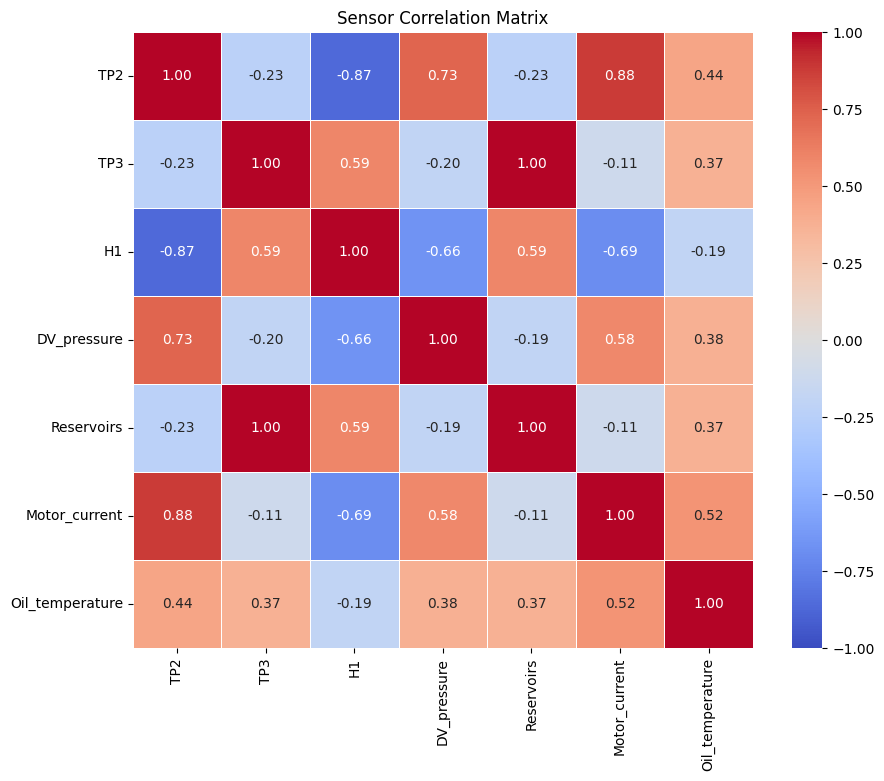

In [30]:
plt.figure(figsize=(10, 8))

# for continuous variables
continuous_vars = ['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Motor_current', 'Oil_temperature']
corr_matrix = df_resampled[continuous_vars].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title('Sensor Correlation Matrix')
plt.show()

The correlation analysis reveals strong and physically meaningful relationships among sensors. Compressor pressure (TP2) shows high correlation with motor current, confirming load-dependent compression, while TP3 and reservoir pressure are perfectly correlated, indicating measurement redundancy. Negative correlations between pressure sensors reflect expected airflow redistribution during operation. Oil temperature exhibits moderate correlation with motor current, consistent with cumulative thermal effects. Overall, the correlation structure validates sensor integrity and highlights opportunities for feature reduction.


## Binary Signal Analysis
Analyze the distribution and frequency of operational states using binary signals such as COMP and Towers.


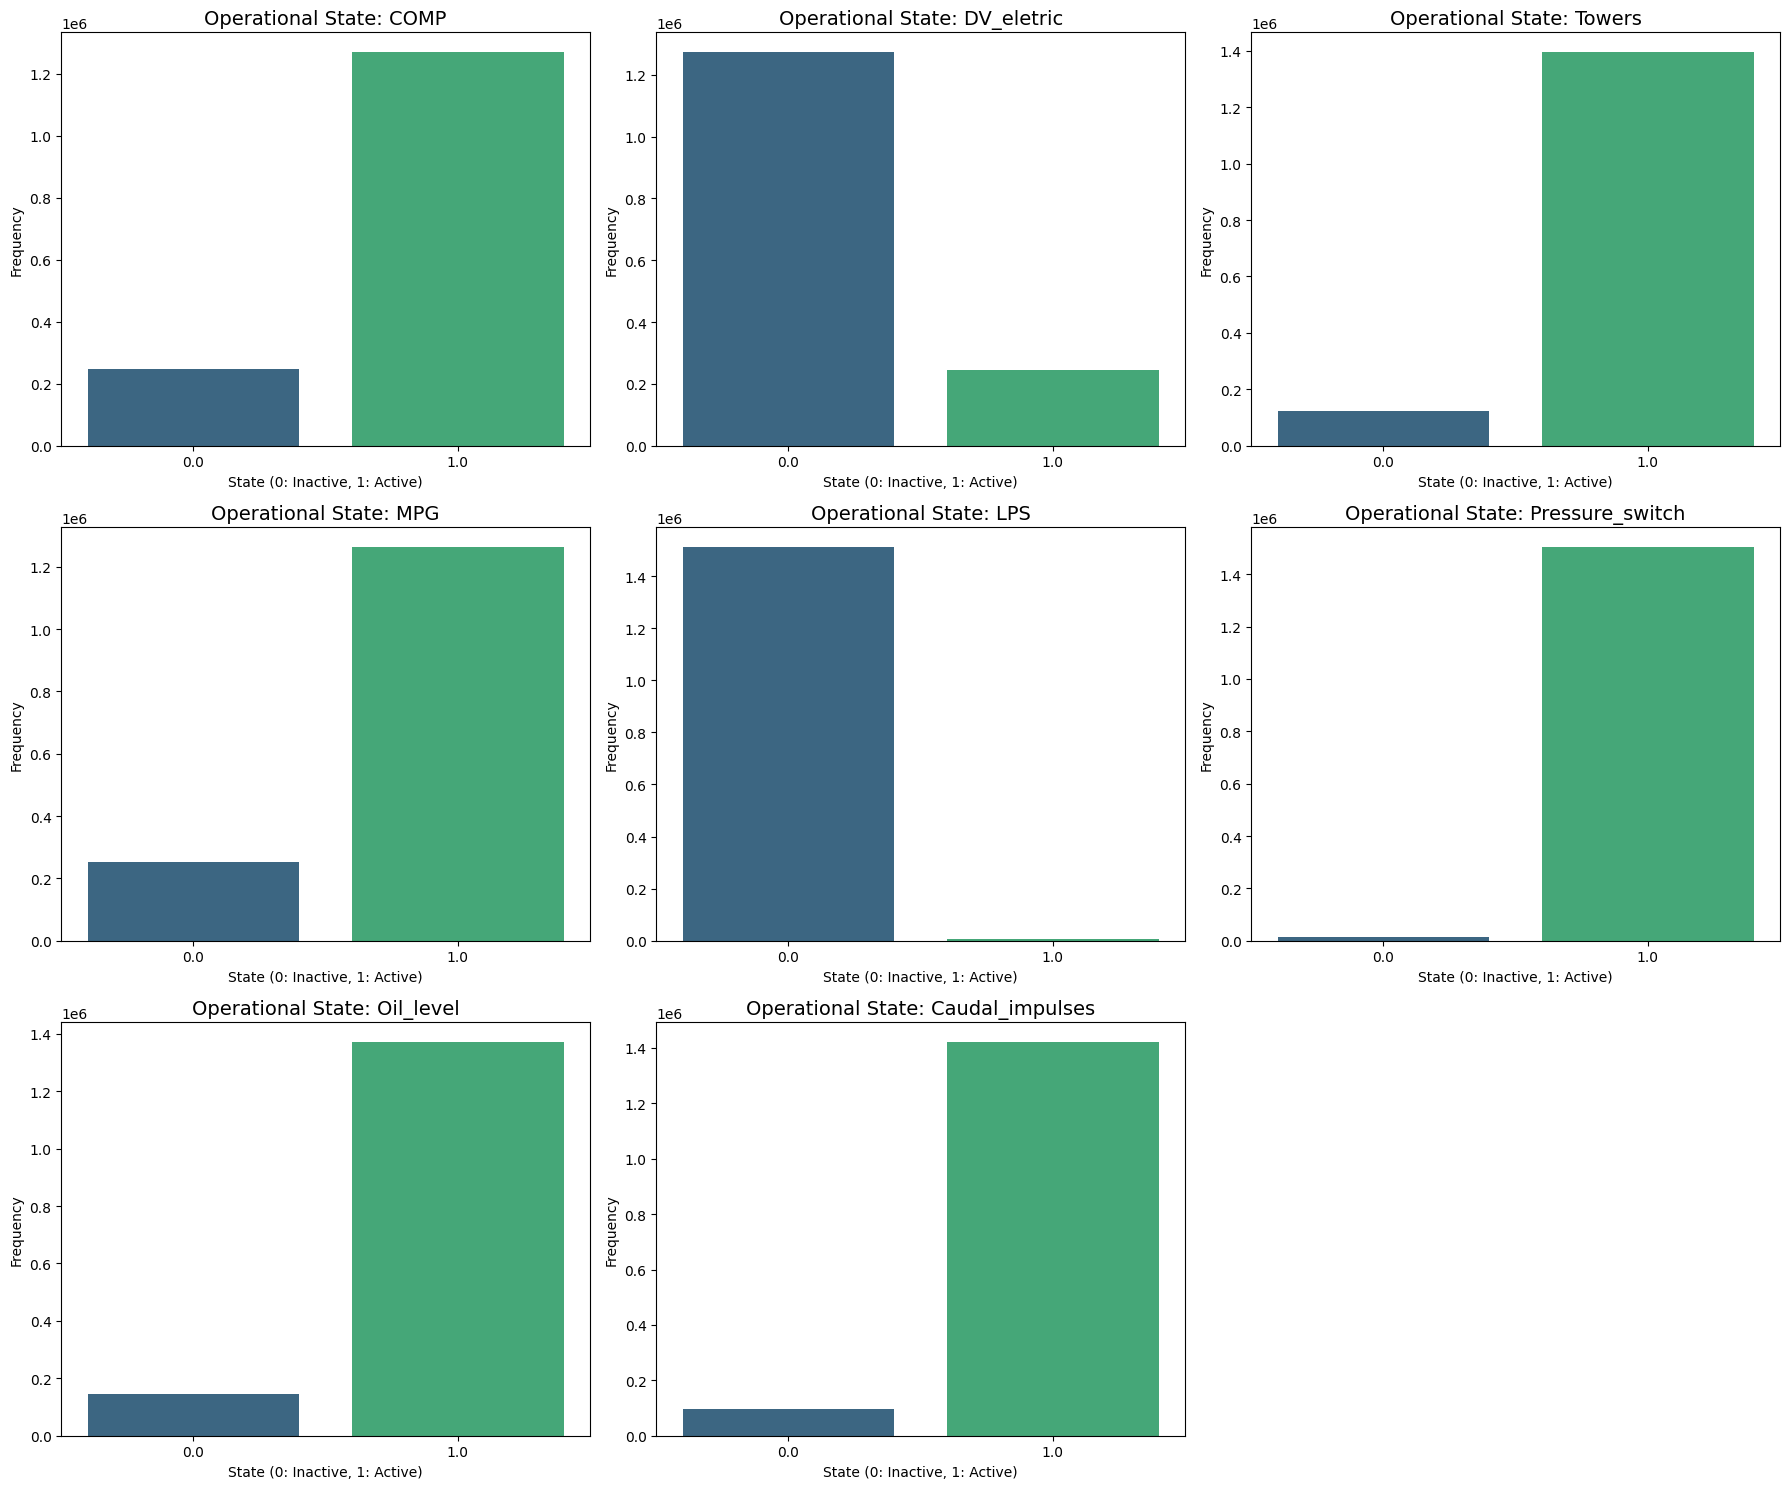

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
axes = axes.flatten()

# Iterate and plot frequencies
for i, col in enumerate(binary_vars):
    # Assign x to hue and set legend=False to resolve FutureWarning
    sns.countplot(x=col, data=df, ax=axes[i], palette='viridis', hue=col, legend=False)
    axes[i].set_title(f'Operational State: {col}', fontsize=14)
    axes[i].set_xlabel('State (0: Inactive, 1: Active)')
    axes[i].set_ylabel('Frequency')

# Hide unused subplots
for j in range(len(binary_vars), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

#### Control Logic Validation
Before modeling, binary control signals are cross-validated against their
expected physical effect on continuous sensors. If COMP, DV_eletric, and
LPS correctly govern motor current and pressure, it confirms sensor
integrity and that the dataset reflects real system behavior rather than
logging artifacts.

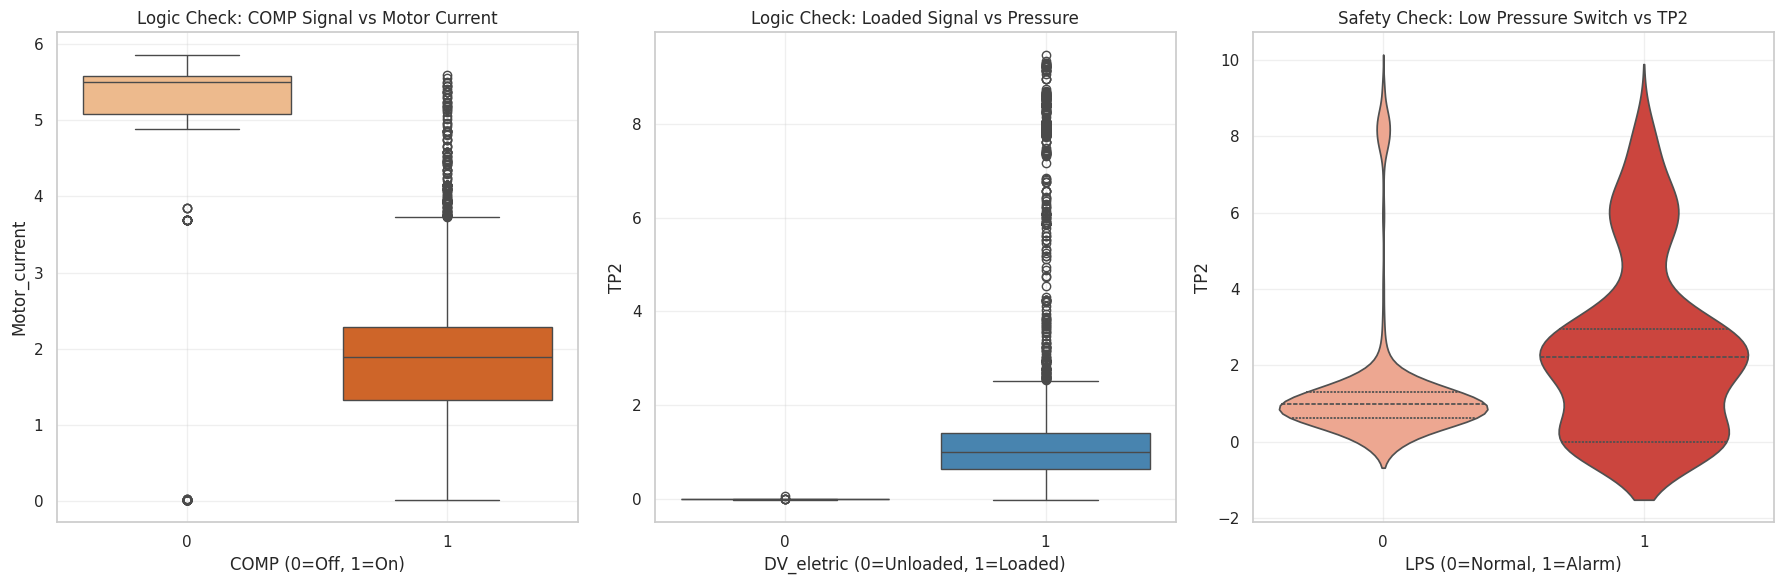

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. SAFETY: Ensure Binary Columns are Integer (0 or 1)
binary_cols = ['COMP', 'DV_eletric', 'LPS']
for col in binary_cols:
    if col in df_resampled.columns:
        df_resampled[col] = df_resampled[col].round().astype(int)

# 2. PLOTTING
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: COMP vs Motor Current (Boxplot)
# Expectation: 0 = Low Current (~0A), 1 = High Current (>3A)
sns.boxplot(
    data=df_resampled,
    x='COMP',
    y='Motor_current',
    hue='COMP',
    palette='Oranges',
    legend=False,
    ax=axes[0]
)
axes[0].set_title('Logic Check: COMP Signal vs Motor Current')
axes[0].set_xlabel('COMP (0=Off, 1=On)')
axes[0].grid(True, alpha=0.3)

# Plot 2: DV_eletric vs Pressure (Boxplot)
# Expectation: 1 (Loaded) should have higher median pressure than 0 (Unloaded)
sns.boxplot(
    data=df_resampled,
    x='DV_eletric',
    y='TP2',
    hue='DV_eletric',
    palette='Blues',
    legend=False,
    ax=axes[1]
)
axes[1].set_title('Logic Check: Loaded Signal vs Pressure')
axes[1].set_xlabel('DV_eletric (0=Unloaded, 1=Loaded)')
axes[1].grid(True, alpha=0.3)

# Plot 3: LPS vs Pressure (Violin Plot)
# Expectation: 1 (Alarm) should look like a "Bulb" at the bottom (Low Pressure)
sns.violinplot(
    data=df_resampled,
    x='LPS',
    y='TP2',
    hue='LPS',
    palette='Reds',
    legend=False,
    inner='quartile',
    ax=axes[2]
)
axes[2].set_title('Safety Check: Low Pressure Switch vs TP2')
axes[2].set_xlabel('LPS (0=Normal, 1=Alarm)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

This section validates whether the **binary control signals** in the system correctly govern the **continuous physical measurements**. Instead of analyzing time trends, the focus here is on **state-based behavior**—how the system behaves when a control signal is ON (`1`) versus OFF (`0`).

---

### COMP Signal vs Motor Current  

**Observation:**
- When **COMP = 0 (On / Loaded)**, motor current is **higher**, clustering around **5–5.5 A**.
- When **COMP = 1 (Off / Unloaded)**, motor current is **lower and more stable**, around **1.5–2 A**.

**Conclusion:**  
This confirms that the COMP control signal operates on Active Low logic (also known as "Negative Logic"), where a logical 0 represents the "Active/On" state and a logical 1 represents the "Inactive/Standby" state. This inversion must be accounted for during feature engineering to ensure the model correctly interprets "0" as the high-stress state.

---

### DV_eletric (Loaded Signal) vs Pressure (TP2)  

**Observation:**
- **DV_eletric = 0 (Unloaded):** Pressure remains low, around **0.5–1 bar**.
- **DV_eletric = 1 (Loaded):** Pressure increases significantly, with a median around **7–8 bar**.

**Conclusion:**  
This aligns with compressor physics:
- Unloaded operation bypasses compression, leading to low pressure.
- Loaded operation compresses air, resulting in pressure buildup.
The DV_eletric signal reliably controls pressure generation and represents the compressor load state accurately.

---

### LPS (Low Pressure Switch) vs Pressure (TP2)  

**Observation:**
LPS = 0 (Normal): The pressure distribution is dense between 8 bar and 10 bar, well above the safety limit.

LPS = 1 (Alarm): Although the trigger is 7 bar, the data density is concentrated almost entirely at 0 bar.

The violin plot reveals the system's Interlock Logic. The switch does not simply stay "active" while pressure is low; rather, crossing the 7-bar threshold triggers an automated protective shutdown. This causes the motor to stop and pressure to collapse to zero immediately.

**Conclusion:**  
The Low Pressure Switch (LPS) functions as a critical safety interlock. An LPS=1 signal indicates a total system shutdown initiated by a breach of the 7-bar safety limit.


### Output: Save Resampled Dataset

The 1-minute resampled dataset is saved as the canonical input for both
Model A and Model B. The timestamp index is preserved in the file to
allow chronological alignment during model training and evaluation.


In [33]:
df_resampled = resample_data(df, '1min')

Resampling to 1min intervals...
Resampled Data Shape: (306960, 15)


In [34]:
df_resampled.to_csv('/content/drive/MyDrive/project/data/input/metropt3_resampled_1min.csv')

## Conclusion and Modeling Strategy

---

### Summary of EDA Findings

#### Data Integrity and Physical Consistency
- The dataset contains over **1.5 million high-frequency sensor readings**, representing a real industrial Air Production Unit (APU).
- Down-sampling to **1-minute intervals** preserves system dynamics while reducing noise and computational cost.
- Control-logic validation confirms that **digital control and safety signals** (`COMP`, `DV_eletric`, `LPS`) correctly govern **physical measurements** (`Motor_current`, `TP2`), validating sensor reliability and system integrity.

---

#### System Behavior: A Discrete State Machine
- Distribution and relationship analysis reveal that the APU does **not behave as a smooth continuous system**.
- Instead, it operates as a **discrete state machine** with three dominant modes:
  - **OFF**: Low motor current and low pressure
  - **OFFLOADED / IDLE**: Moderate current with stabilized pressure
  - **LOADED**: High current and high pressure
- The relationship between motor current and pressure is **non-linear and state-dependent**, especially during transitions such as startup and unloading.

---

#### Failure and Degradation Characteristics
- Failures are **not identifiable through single-point thresholds or static anomalies**.
- Instead, degradation manifests as **temporal patterns**, including:
  - Gradual increases in **oil temperature** (thermal stress and wear)
  - Increasing variance in **motor current**
  - Repeated or deeper **pressure drops** prior to failure events
- These behaviors confirm that failures are **sequence-level phenomena**, not instantaneous outliers.

---

### Implications for Machine Learning

#### Why Simple Models Are Insufficient
- Linear and static models (e.g., Linear Regression, simple classifiers) cannot capture:
  - Multi-modal operating behavior
  - Temporal dependencies
  - Control-driven state transitions
- Therefore, **time-series deep learning models** are required.

---

#### Feature Strategy and Correlated Variables
- Correlation analysis identifies strongly related sensor pairs (e.g., `TP3` and `Reservoirs`).
- For **deep learning models (LSTM / Autoencoder)**:
  - Highly correlated variables are **retained**
  - Sequence models benefit from redundant views of system state
- Feature reduction may be considered only for **classical or interpretable baseline models**, not for the primary deep learning approach.

---

### Final Modeling Strategy

#### Model A: Anomaly Detection (Primary Model)
**LSTM Autoencoder**

**Rationale:**
- Learns normal operational sequences across multiple states
- Detects anomalies through elevated reconstruction error
- Suitable for scenarios with limited or weak failure labels

**Training Approach:**
- Train primarily on **normal operating windows**
- Flag deviations from learned patterns as potential anomalies

---

#### Model B: Forecasting / Early Warning (Secondary Model)
**Supervised LSTM Predictor**

**Rationale:**
- Predicts near-term future values (e.g., pressure or temperature)
- Increasing prediction error can serve as an early warning signal

---

#### Input Design
- Sliding windows of **30 minutes** (30 time steps at 1-minute resolution)
- Multivariate input: **7 continuous sensors only**
  (pressure, current, temperature)
- Binary signals excluded from model input — reserved for
  post-hoc validation and anomaly attribution

---

### Final Conclusion

- The EDA confirms that the APU is a **state-driven, nonlinear, and temporally dependent system**.
- Control logic and safety mechanisms behave consistently with physical measurements.
- Failure patterns emerge only when **temporal context** is considered.
- Consequently, **LSTM-based deep learning models** are the most appropriate and justified choice for this problem.
